# Lab 2 : Supervised Learning

## Plotting the data

In [10]:
import numpy as np
import pylab as plt
import scipy as sp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

In [11]:
data = np.load("ECoG.npz")

Xall = data["Xall"]
Yall = data["Yall"]
Fe = data["Fe"]

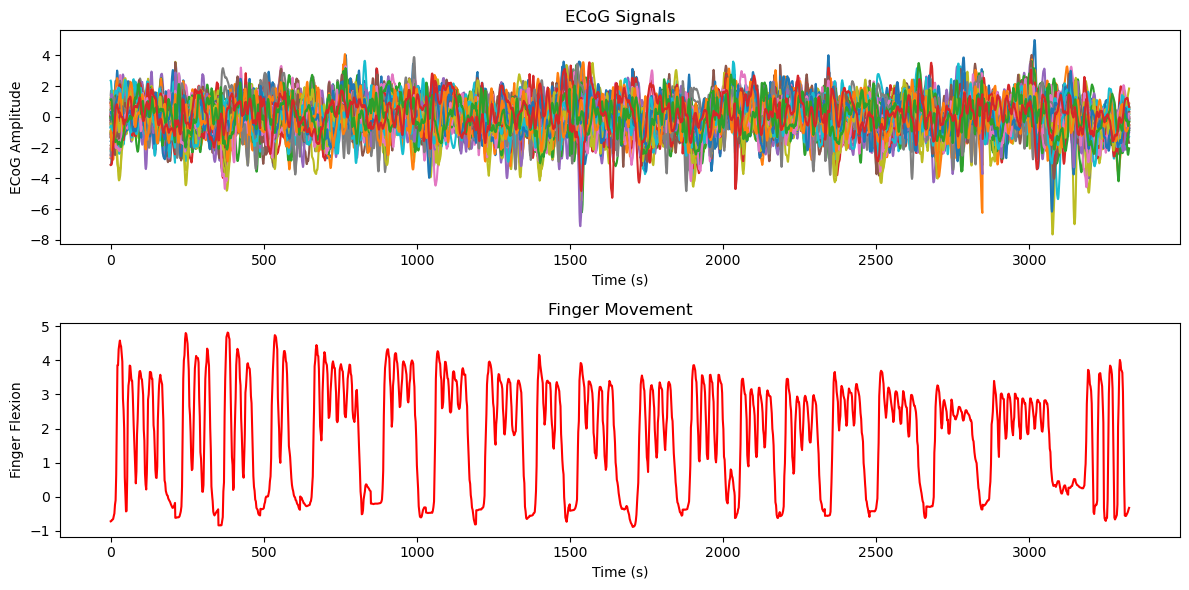

In [12]:
# Plot ECoG signals and finger movement on the same figure
plt.figure(figsize=(12, 6))

# Plot ECoG signals
plt.subplot(2, 1, 1)  # Create the first subplot for ECoG signals
plt.title('ECoG Signals')
plt.xlabel('Time (s)')
plt.ylabel('ECoG Amplitude')
plt.plot(Xall, label='ECoG Signals')

# Plot finger movement
plt.subplot(2, 1, 2)  # Create the second subplot for finger movement
plt.title('Finger Movement')
plt.xlabel('Time (s)')
plt.ylabel('Finger Flexion')
plt.plot(Yall, label='Finger Flexion', color='red')

# Show the plot
plt.tight_layout()
plt.show()

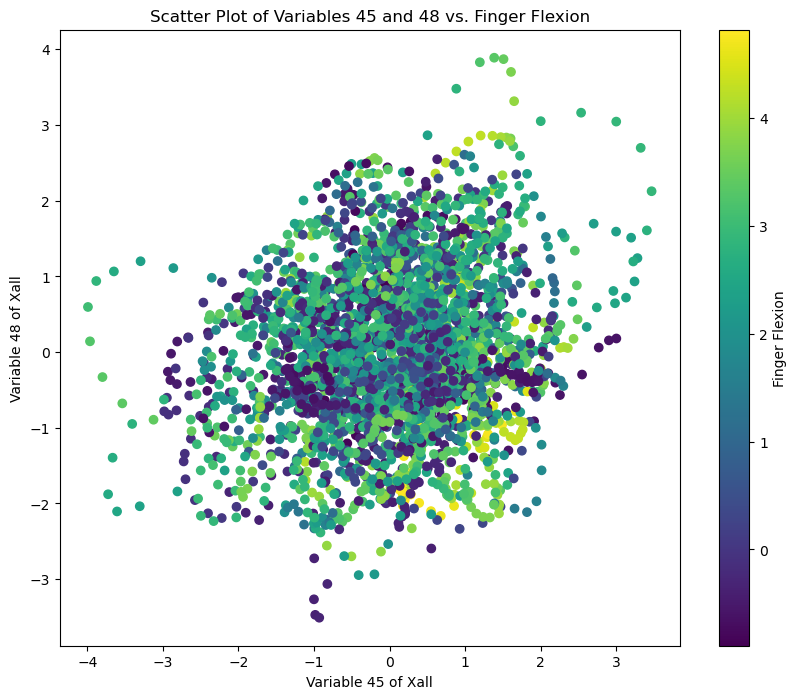

In [13]:
# Variables 45 and 48 from Xall
X45 = Xall[:, 44]
X48 = Xall[:, 47]

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X45, X48, c=Yall, marker='o')
plt.colorbar(label='Finger Flexion')
plt.xlabel('Variable 45 of Xall')
plt.ylabel('Variable 48 of Xall')
plt.title('Scatter Plot of Variables 45 and 48 vs. Finger Flexion')
plt.show()

In [14]:
# Define the number of training samples
n_train = 1000

# Split the data into training and testing sets
X_train = Xall[:n_train, :]
Y_train = Yall[:n_train]
print("X_train shape : ",X_train.shape)
print("Y_train shape : ",Y_train.shape)

X_test = Xall[n_train:, :]
Y_test = Yall[n_train:]
print("X_test shape : ",X_test.shape)
print("Y_test shape : ",Y_test.shape)



X_train shape :  (1000, 64)
Y_train shape :  (1000, 1)
X_test shape :  (2327, 64)
Y_test shape :  (2327, 1)


## Least Squares regression (LS)


In [15]:
n_train_samples, n_features = X_train.shape

# Create a column of ones
ones_column = np.ones((n_train_samples, 1))

# Concatenate the ones column with the training data
X_tilde = np.concatenate((ones_column, X_train), axis=1)

In [16]:

# Solve the linear problem using the normal equation
XTX = np.dot(X_tilde.T, X_tilde)  # X^T * X
XTY = np.dot(X_tilde.T, Y_train)  # X^T * Y

# Solve for the coefficients (w) including the bias term
params = np.linalg.solve(XTX, XTY)

# Extract the coefficients (w) and the bias (b)
w = params[1:]  # Exclude the first element which is the bias term
b = params[0]   # The first element is the bias term

# w now contains the coefficients, and b contains the bias term

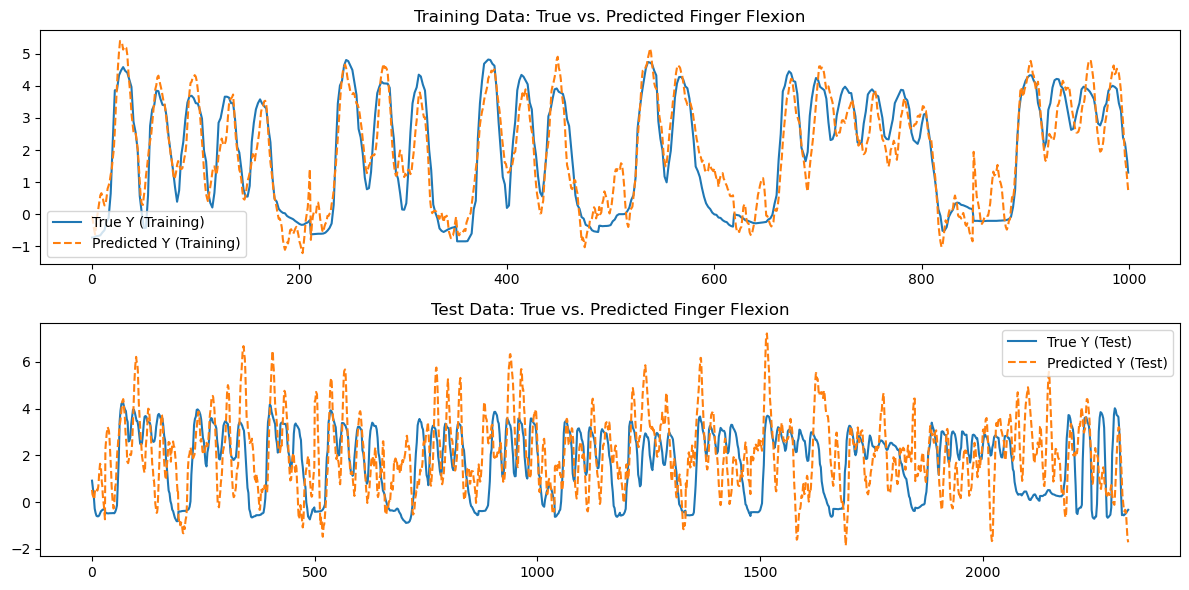

In [17]:
# Calculate predictions on the training set
Y_train_pred = np.dot(X_tilde, np.concatenate(([b], w)))

# Calculate predictions on the test set
X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
Y_test_pred = np.dot(X_test_tilde, np.concatenate(([b], w)))

# Plot the predictions vs. true values for training data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(Y_train, label='True Y (Training)')
plt.plot(Y_train_pred, label='Predicted Y (Training)', linestyle='dashed')
plt.title('Training Data: True vs. Predicted Finger Flexion')
plt.legend()

# Plot the predictions vs. true values for test data
plt.subplot(2, 1, 2)
plt.plot(Y_test, label='True Y (Test)')
plt.plot(Y_test_pred, label='Predicted Y (Test)', linestyle='dashed')
plt.title('Test Data: True vs. Predicted Finger Flexion')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Calculate MSE and R2 on training data
mse_train = mean_squared_error(Y_train, Y_train_pred)
r2_train = r2_score(Y_train, Y_train_pred)

# Calculate MSE and R2 on test data
mse_test = mean_squared_error(Y_test, Y_test_pred)
r2_test = r2_score(Y_test, Y_test_pred)

# Print the results
print(f"Training MSE: {mse_train:.4f}")
print(f"Training R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test R2: {r2_test:.4f}")

Training MSE: 0.5041
Training R2: 0.8395
Test MSE: 3.0455
Test R2: -0.4282


In [19]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_tilde, Y_train)

# Get the estimated coefficients and intercept from the model
sklearn_coefs = model.coef_
sklearn_intercept = model.intercept_

In [20]:
# Compare with the previously estimated coefficients and intercept
coef_diff = np.abs(w - sklearn_coefs)
intercept_diff = np.abs(b - sklearn_intercept)

# Check if the differences are very small (close to zero)
coefficients_match = np.all(coef_diff < 1e-6)
intercept_matches = np.abs(intercept_diff) < 1e-6

print(coefficients_match)
print("coefficients difference : ", coef_diff)
print(intercept_matches)
print("intercept difference : ", intercept_diff)

if coefficients_match and intercept_matches:
    print("The coefficients and intercept match.")
else:
    print("The coefficients and intercept do not match.")

False
coefficients difference :  [[9.15069376e-02 1.87350135e-15 2.00123171e-01 ... 1.44877270e-01
  1.33949620e-01 6.60942741e-01]
 [1.08616234e-01 2.00123171e-01 6.02295991e-15 ... 3.45000441e-01
  6.61735515e-02 4.60819570e-01]
 [7.30577356e-02 1.84492020e-02 1.81673969e-01 ... 1.63326472e-01
  1.15500418e-01 6.42493539e-01]
 ...
 [2.36384208e-01 1.44877270e-01 3.45000441e-01 ... 2.49800181e-16
  2.78826890e-01 8.05820011e-01]
 [4.24426821e-02 1.33949620e-01 6.61735515e-02 ... 2.78826890e-01
  2.78249646e-15 5.26993121e-01]
 [5.69435803e-01 6.60942741e-01 4.60819570e-01 ... 8.05820011e-01
  5.26993121e-01 1.19904087e-14]]
[ True]
intercept difference :  [1.33226763e-15]
The coefficients and intercept do not match.


## Ridge regression

In [21]:
def train_and_evaluate_ridge(alpha, print_results=True):
    # Create a Ridge regression model with the specified alpha
    ridge_model = Ridge(alpha=alpha)

    # Fit the Ridge model to the training data
    ridge_model.fit(X_tilde, Y_train)

    # Predictions on the training set
    Y_train_pred_ridge = ridge_model.predict(X_tilde)

    # Predictions on the test set
    X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
    Y_test_pred_ridge = ridge_model.predict(X_test_tilde)

    # Calculate performance metrics on training and test data
    mse_train_ridge = mean_squared_error(Y_train, Y_train_pred_ridge)
    r2_train_ridge = r2_score(Y_train, Y_train_pred_ridge)
    mse_test_ridge = mean_squared_error(Y_test, Y_test_pred_ridge)
    r2_test_ridge = r2_score(Y_test, Y_test_pred_ridge)

    if print_results:
        print(f"Ridge Regression with λ = {alpha}\n")
        print(f"Training MSE: {mse_train_ridge:.4f}")
        print(f"Training R2: {r2_train_ridge:.4f}")
        print(f"Test MSE: {mse_test_ridge:.4f}")
        print(f"Test R2: {r2_test_ridge:.4f}")

In [22]:
train_and_evaluate_ridge(alpha=1, print_results=True)

Ridge Regression with λ = 1

Training MSE: 0.5042
Training R2: 0.8395
Test MSE: 3.0038
Test R2: -0.4086


In [23]:
# Define a range of λ values
lambda_values = np.logspace(-3, 5, 100)  # From 10^-3 to 10^5

# Initialize lists to store MSE values and coefficients for each λ
mse_train_values = []
mse_test_values = []
coefficients = []

# Iterate over λ values
for alpha in lambda_values:
    # Create a Ridge regression model with the current λ
    ridge_model = Ridge(alpha=alpha)

    # Fit the Ridge model to the training data
    ridge_model.fit(X_tilde, Y_train)

    # Predictions on the training set
    Y_train_pred_ridge = ridge_model.predict(X_tilde)

    # Predictions on the test set
    X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
    Y_test_pred_ridge = ridge_model.predict(X_test_tilde)

    # Calculate MSE on training and test data
    mse_train = mean_squared_error(Y_train, Y_train_pred_ridge)
    mse_test = mean_squared_error(Y_test, Y_test_pred_ridge)

    # Store MSE values
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)

    # Store coefficients for this λ
    coefficients.append(ridge_model.coef_)

# Convert the lists to arrays for plotting
mse_train_values = np.array(mse_train_values)
mse_test_values = np.array(mse_test_values)
coefficients = np.array(coefficients)

# Find the index of the minimum test MSE value
best_lambda_index = np.argmin(mse_test_values)

# Get the λ value corresponding to the minimum test MSE
best_lambda = lambda_values[best_lambda_index]

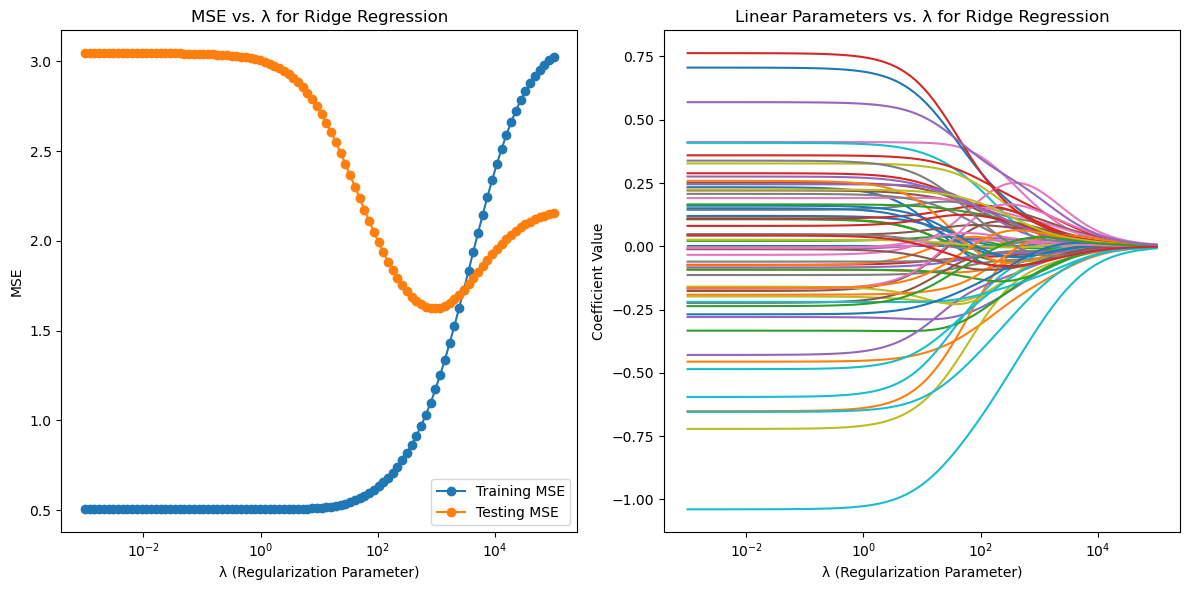

In [24]:

# Plot the evolution of MSE on training and testing data as a function of λ
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.semilogx(lambda_values, mse_train_values, label='Training MSE', marker='o')
plt.semilogx(lambda_values, mse_test_values, label='Testing MSE', marker='o')
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('MSE')
plt.title('MSE vs. λ for Ridge Regression')
plt.legend()

# Plot the evolution of linear parameters as a function of λ
plt.subplot(1, 2, 2)
for i in range(coefficients.shape[1]):
    plt.semilogx(lambda_values, coefficients[:, i])
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('Coefficient Value')
plt.title('Linear Parameters vs. λ for Ridge Regression')

plt.tight_layout()
plt.show()

In [25]:
train_and_evaluate_ridge(alpha=best_lambda, print_results=True)

Ridge Regression with λ = 954.5484566618347

Training MSE: 1.1719
Training R2: 0.6268
Test MSE: 1.6239
Test R2: 0.2385


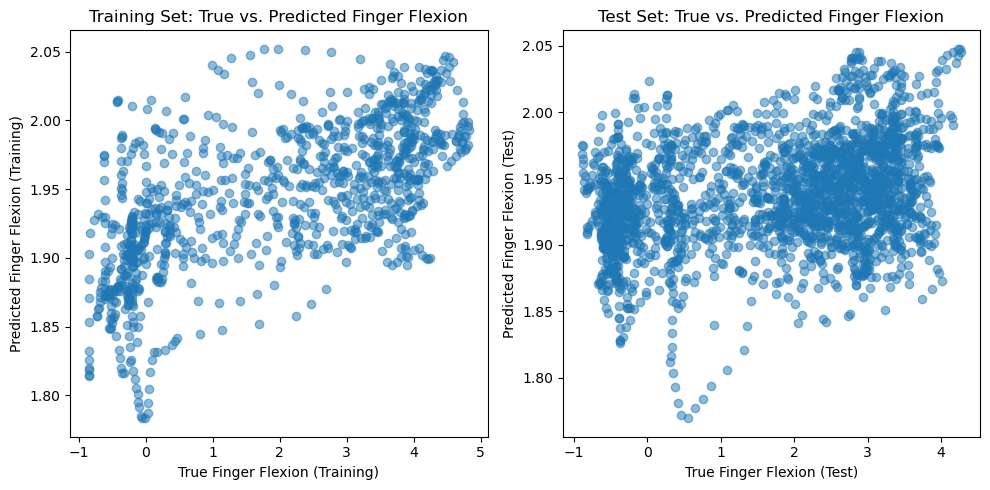

In [54]:
# Scatter plot for training set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y_train, Y_train_pred_ridge, alpha=0.5)
plt.xlabel('True Finger Flexion (Training)')
plt.ylabel('Predicted Finger Flexion (Training)')
plt.title('Training Set: True vs. Predicted Finger Flexion')

# Scatter plot for test set
plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_test_pred_ridge, alpha=0.5)
plt.xlabel('True Finger Flexion (Test)')
plt.ylabel('Predicted Finger Flexion (Test)')
plt.title('Test Set: True vs. Predicted Finger Flexion')

plt.tight_layout()
plt.show()

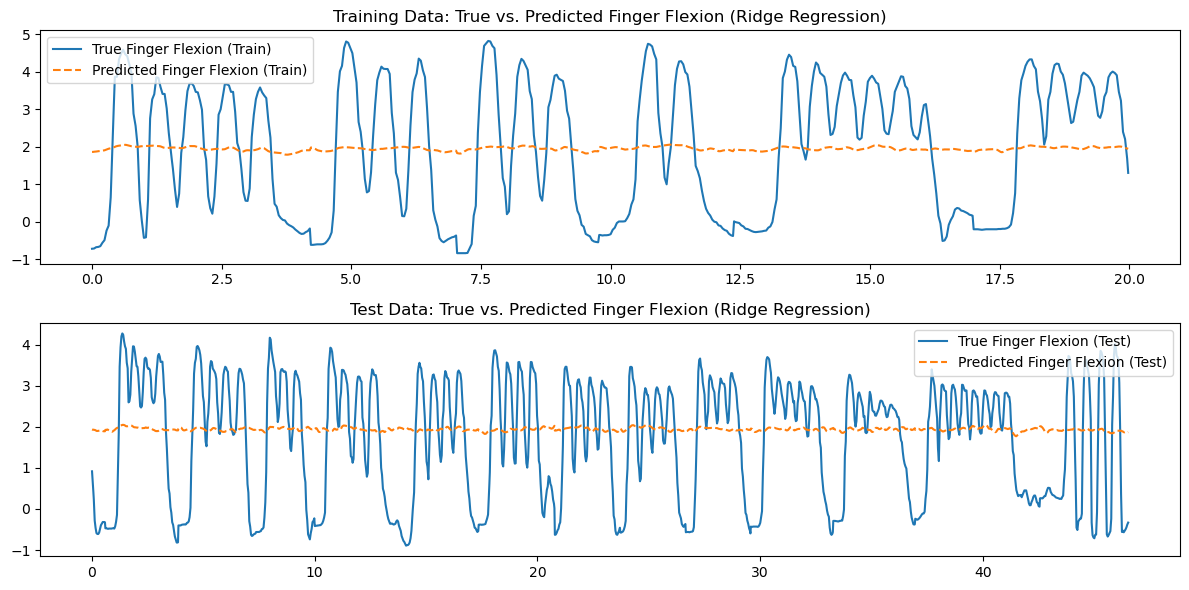

In [52]:
# Calculate time points based on the sampling frequency Fe
time_points_test = np.arange(Y_test.shape[0]) / Fe
time_points_test = time_points_test.flatten()

# Calculate time points based on the sampling frequency Fe for training data
time_points_train = np.arange(Y_train.shape[0]) / Fe
time_points_train = time_points_train.flatten()

# Plot the predictions vs. true values for training data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_points_train, Y_train, label='True Finger Flexion (Train)')
plt.plot(time_points_train, Y_train_pred_ridge, label='Predicted Finger Flexion (Train)', linestyle='dashed')
plt.title('Training Data: True vs. Predicted Finger Flexion (Ridge Regression)')
plt.legend()

# Plot the predictions vs. true values for test data
plt.subplot(2, 1, 2)
plt.plot(time_points_test, Y_test, label='True Finger Flexion (Test)')
plt.plot(time_points_test, Y_test_pred_ridge, label='Predicted Finger Flexion (Test)', linestyle='dashed')
plt.title('Test Data: True vs. Predicted Finger Flexion (Ridge Regression)')
plt.legend()

plt.tight_layout()
plt.show()

**The first set of estimations were for the LS (Least Squares) estimator:**

- LS Training MSE: 0.5041
- LS Training R2: 0.8395
- LS Test MSE: 3.0455
- LS Test R2: -0.4282

**The second set of estimations were for Ridge Regression with the best lambda (λ = 954.5484566618347):**

- Ridge Training MSE: 1.1719
- Ridge Training R2: 0.6268
- Ridge Test MSE: 1.6239
- Ridge Test R2: 0.2385

**Dicussion:**

- The LS estimator initially performs well on the training data with lower MSE and higher R2.
- However, it fails to generalize to the test data, resulting in a high test MSE and a negative test R2, indicating overfitting.
- In contrast, Ridge Regression with the best lambda shows better generalization to the test data with lower test MSE and a positive test R2.

The LS estimator, while performing well on the training data, struggles to generalize to unseen data, which is a common issue when dealing with high-dimensional or noisy datasets. Ridge Regression, with appropriate regularization (λ), can help mitigate overfitting and improve generalization performance.

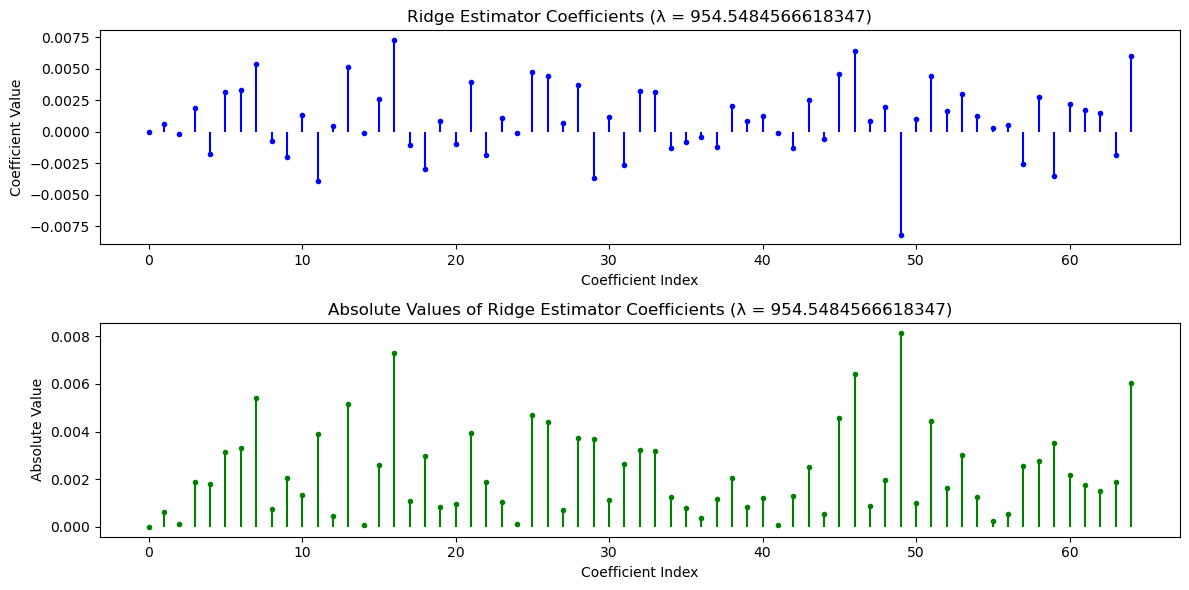

In [28]:
# Reshape the coefficients for Ridge estimator
ridge_coef = ridge_model.coef_.reshape(-1)

# Plot Ridge estimator coefficients and their absolute values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(ridge_coef, basefmt=" ", markerfmt="b.", linefmt="b-")
plt.title("Ridge Estimator Coefficients (λ = 954.5484566618347)")
plt.xlabel("Coefficient Index")
plt.ylabel("Coefficient Value")

plt.subplot(2, 1, 2)
plt.stem(np.abs(ridge_coef), basefmt=" ", markerfmt="g.", linefmt="g-")
plt.title("Absolute Values of Ridge Estimator Coefficients (λ = 954.5484566618347)")
plt.xlabel("Coefficient Index")
plt.ylabel("Absolute Value")

plt.tight_layout()
plt.show()

## Variable selection with the Lasso

In [29]:
# Create a Lasso regression model with the default alpha (regularization parameter)
lasso_model = Lasso()

# Fit the Lasso model to the training data
lasso_model.fit(X_tilde, Y_train)

Lasso()

In [30]:
# Predictions on the training set
Y_train_pred_lasso = lasso_model.predict(X_tilde)

# Predictions on the test set
X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
Y_test_pred_lasso = lasso_model.predict(X_test_tilde)

# Calculate performance metrics on training and test data
mse_train_lasso = mean_squared_error(Y_train, Y_train_pred_lasso)
r2_train_lasso = r2_score(Y_train, Y_train_pred_lasso)
mse_test_lasso = mean_squared_error(Y_test, Y_test_pred_lasso)
r2_test_lasso = r2_score(Y_test, Y_test_pred_lasso)

# Print performance metrics
print("Lasso Regression Performance Metrics:\n")
print(f"Training MSE: {mse_train_lasso:.4f}")
print(f"Training R2: {r2_train_lasso:.4f}")
print(f"Test MSE: {mse_test_lasso:.4f}")
print(f"Test R2: {r2_test_lasso:.4f}")

# Inspect the estimated linear model coefficients (Lasso)
lasso_coefs = lasso_model.coef_
print("\nEstimated Lasso Coefficients:")
print(lasso_coefs)


Lasso Regression Performance Metrics:

Training MSE: 3.1406
Training R2: 0.0000
Test MSE: 2.1907
Test R2: -0.0273

Estimated Lasso Coefficients:
[ 0.  0.  0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0.
 -0.  0. -0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0. -0. -0.
 -0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
  0.  0.  0. -0.  0. -0.  0.  0.  0. -0.  0.]


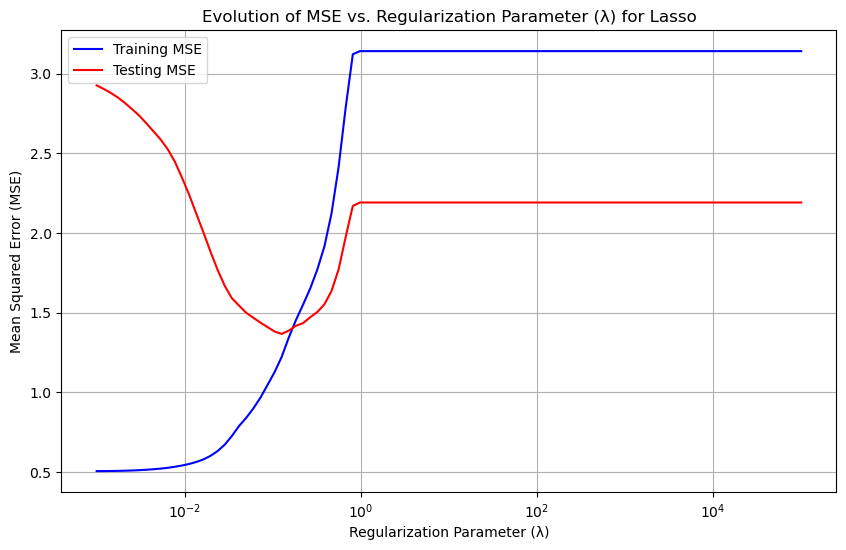

In [31]:
# Define a range of regularization parameters (λ)
lst_reg = np.logspace(-3, 5, 100)

# Initialize empty lists to store MSE values for training and testing
mse_train_values = []
mse_test_values = []

# Iterate over each regularization parameter
for i, reg in enumerate(lst_reg):
    # Create and fit the Lasso model for the current λ
    lasso_model = Lasso(alpha=reg)
    lasso_model.fit(X_tilde, Y_train)

    # Predictions on the training set
    Y_train_pred = lasso_model.predict(X_tilde)

    # Predictions on the test set
    X_test_tilde = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
    Y_test_pred = lasso_model.predict(X_test_tilde)

    # Calculate MSE for training and testing
    mse_train = mean_squared_error(Y_train, Y_train_pred)
    mse_test = mean_squared_error(Y_test, Y_test_pred)

    # Append MSE values to the lists
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)

# Plot the evolution of MSE on training and testing data as a function of λ
plt.figure(figsize=(10, 6))
plt.semilogx(lst_reg, mse_train_values, label='Training MSE', color='blue')
plt.semilogx(lst_reg, mse_test_values, label='Testing MSE', color='red')
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Evolution of MSE vs. Regularization Parameter (λ) for Lasso')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Find the index of the minimum test MSE
best_lambda_index = np.argmin(mse_test_values)

# Get the corresponding best lambda value
best_lambda = lst_reg[best_lambda_index]

# Create and fit the Lasso model with the best lambda
best_lasso_model = Lasso(alpha=best_lambda)
best_lasso_model.fit(X_tilde, Y_train)

# Print the best lambda value
print(f"The best lambda value selected: {best_lambda}")

# Now you have the best Lasso model estimated with the best lambda value


The best lambda value selected: 0.1261856883066021


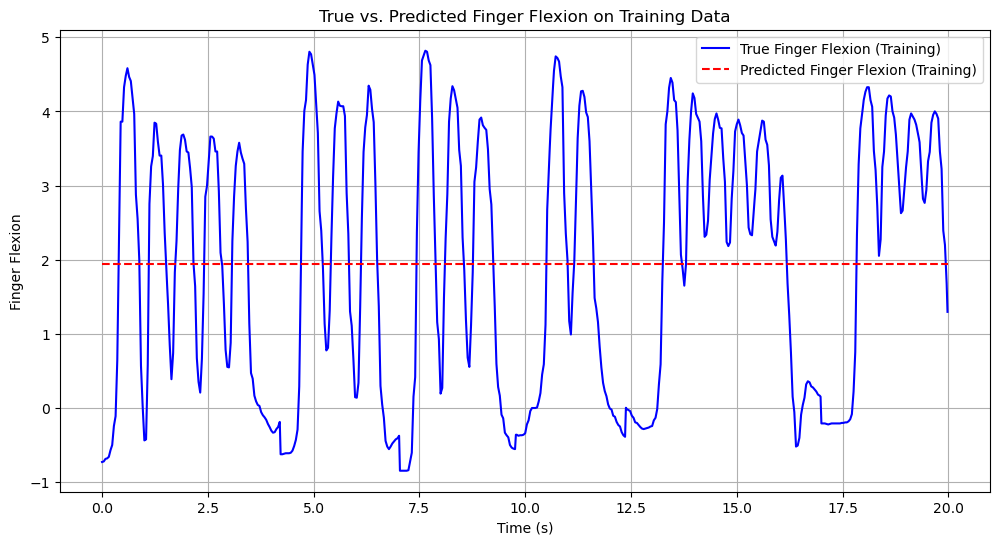

In [47]:
# Reshape time_vector_train to match the shape of Y_train
time_vector_train = np.arange(0, len(Y_train)) / Fe
time_vector_train = time_vector_train.reshape(-1, 1)

# Plot the true finger flexion values and predicted values for training set
plt.figure(figsize=(12, 6))
plt.plot(time_vector_train, Y_train, label='True Finger Flexion (Training)', color='blue')
plt.plot(time_vector_train, Y_train_pred_lasso, label='Predicted Finger Flexion (Training)', linestyle='dashed', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Finger Flexion')
plt.title('True vs. Predicted Finger Flexion on Training Data')
plt.legend()
plt.grid(True)
plt.show()


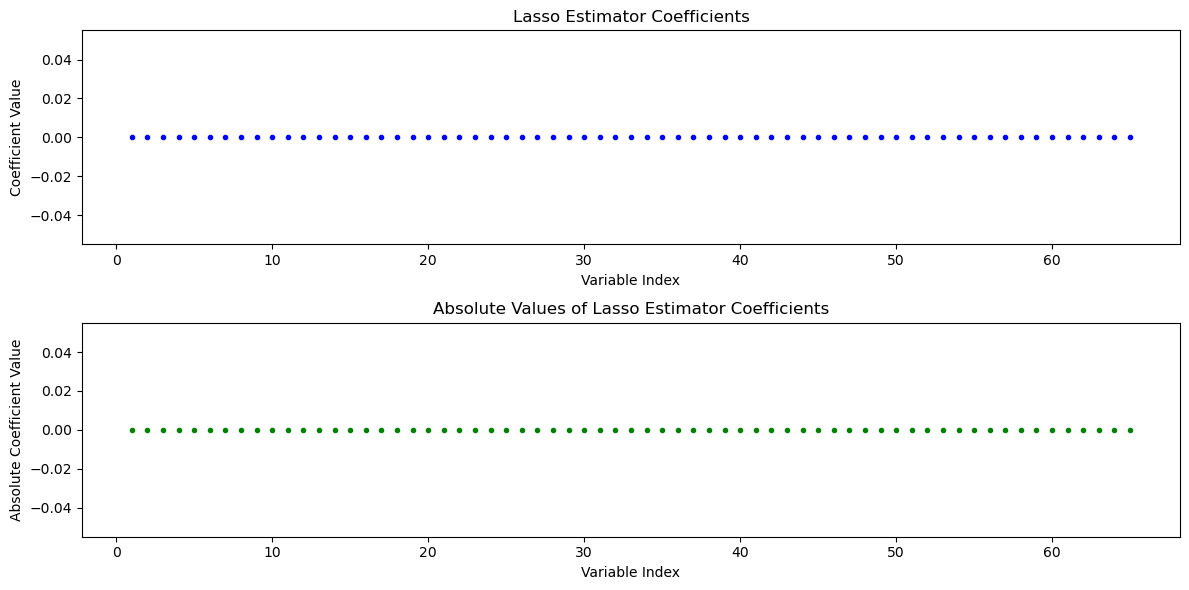

The two most important variables are: [65 32]


In [34]:
# Get the coefficients and their absolute values from the Lasso model
lasso_coefs = lasso_model.coef_
lasso_abs_coefs = np.abs(lasso_coefs)

# Create an array of variable indices for labeling the coefficients
variable_indices = np.arange(1, len(lasso_coefs) + 1)

# Sort the coefficients and variable indices based on absolute coefficient values
sorted_indices = np.argsort(lasso_abs_coefs)[::-1]
sorted_coefs = lasso_coefs[sorted_indices]
sorted_variable_indices = variable_indices[sorted_indices]

# Plot the coefficients and their absolute values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(variable_indices, sorted_coefs, basefmt=" ", markerfmt="b.", linefmt="b-")
plt.title("Lasso Estimator Coefficients")
plt.xlabel("Variable Index")
plt.ylabel("Coefficient Value")

plt.subplot(2, 1, 2)
plt.stem(variable_indices, lasso_abs_coefs, basefmt=" ", markerfmt="g.", linefmt="g-")
plt.title("Absolute Values of Lasso Estimator Coefficients")
plt.xlabel("Variable Index")
plt.ylabel("Absolute Coefficient Value")

plt.tight_layout()
plt.show()

# Print the indices of the two most important variables
most_important_variables = sorted_variable_indices[:2]
print("The two most important variables are:", most_important_variables)


In [35]:
# Count the number of non-zero coefficients in the Lasso model
num_selected_features = np.sum(lasso_coefs != 0)

# Print the number of selected features
print("Number of selected features by Lasso:", num_selected_features)


Number of selected features by Lasso: 0


## Nonlinear regression


### 1) Random Forest

In [36]:
# Create and fit the RandomForestRegressor with default parameters
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, Y_train.ravel())

# Make predictions on the test set
Y_test_pred_rf = rf_regressor.predict(X_test)

# Compute performance metrics
mse_rf = mean_squared_error(Y_test, Y_test_pred_rf)
r2_rf = r2_score(Y_test, Y_test_pred_rf)

print("RandomForestRegressor Performance Metrics:\n")
print(f"Test MSE: {mse_rf:.4f}")
print(f"Test R2: {r2_rf:.4f}")


RandomForestRegressor Performance Metrics:

Test MSE: 1.6463
Test R2: 0.2280


In [37]:
# Define the hyperparameters and their possible values
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestRegressor
rf_regressor = RandomForestRegressor()

# Perform random search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dist,
                                   n_iter=10, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the random search to the data
random_search.fit(X_train, Y_train.ravel())

# Get the best hyperparameters
best_params = random_search.best_params_

# Create a RandomForestRegressor with the best hyperparameters
best_rf_regressor = RandomForestRegressor(**best_params)

# Fit the model with the best hyperparameters
best_rf_regressor.fit(X_train, Y_train.ravel())

# Make predictions on the test set
Y_test_pred_best_rf = best_rf_regressor.predict(X_test)

# Compute performance metrics with the best hyperparameters
mse_best_rf = mean_squared_error(Y_test, Y_test_pred_best_rf)
r2_best_rf = r2_score(Y_test, Y_test_pred_best_rf)

print("Best RandomForestRegressor Performance Metrics:")
print(f"Test MSE: {mse_best_rf:.4f}")
print(f"Test R2: {r2_best_rf:.4f}")
print("Best Hyperparameters:", best_params)

Best RandomForestRegressor Performance Metrics:
Test MSE: 1.6846
Test R2: 0.2100
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


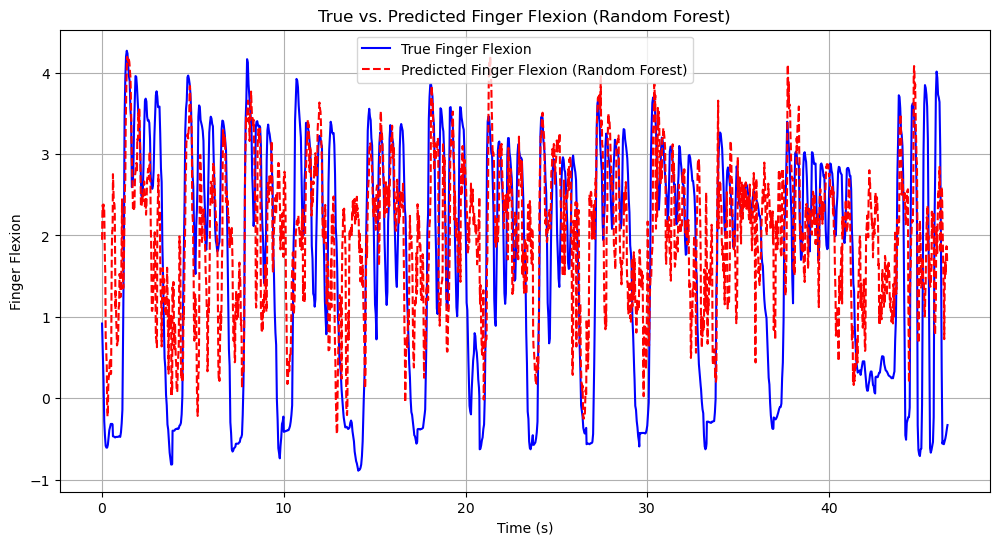

In [38]:
time_vector_test = np.arange(X_test.shape[0]) / Fe
time_vector_test = np.squeeze(time_vector_test)

# Plot the true finger flexion values and predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(time_vector_test, Y_test, label='True Finger Flexion', color='blue')
plt.plot(time_vector_test, Y_test_pred_best_rf, label='Predicted Finger Flexion (Random Forest)', linestyle='dashed', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Finger Flexion')
plt.title('True vs. Predicted Finger Flexion (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

### 2) SVR

In [39]:
# Create and fit the SVR with default parameters
svr_regressor = SVR()
svr_regressor.fit(X_train, Y_train.ravel())

# Make predictions on the test set
Y_test_pred_svr = svr_regressor.predict(X_test)

# Compute performance metrics
mse_svr = mean_squared_error(Y_test, Y_test_pred_svr)
r2_svr = r2_score(Y_test, Y_test_pred_svr)

print("SVR Performance Metrics:\n")
print(f"Test MSE: {mse_svr:.4f}")
print(f"Test R2: {r2_svr:.4f}")

SVR Performance Metrics:

Test MSE: 1.5152
Test R2: 0.2895


In [40]:
# Create an SVR model
svr = SVR()

# Define the parameter distribution to sample from
param_dist = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': sp.stats.loguniform(0.1, 1000),
    'gamma': sp.stats.loguniform(0.001, 10)
}

# Perform a randomized search using cross-validation
random_search = RandomizedSearchCV(svr, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train, Y_train.ravel())

# Get the best SVR model
best_svr = random_search.best_estimator_

# Predict on the test set
Y_test_pred_svr = best_svr.predict(X_test)

# Calculate performance metrics on test data
mse_test_svr = mean_squared_error(Y_test, Y_test_pred_svr)
r2_test_svr = r2_score(Y_test, Y_test_pred_svr)

# Print the results
print(f"Best SVR Model Parameters: {best_svr.get_params()}")
print(f"Test MSE: {mse_test_svr:.4f}")
print(f"Test R2: {r2_test_svr:.4f}")


Best SVR Model Parameters: {'C': 1.13475283027631, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.02427361531017985, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Test MSE: 1.5611
Test R2: 0.2680


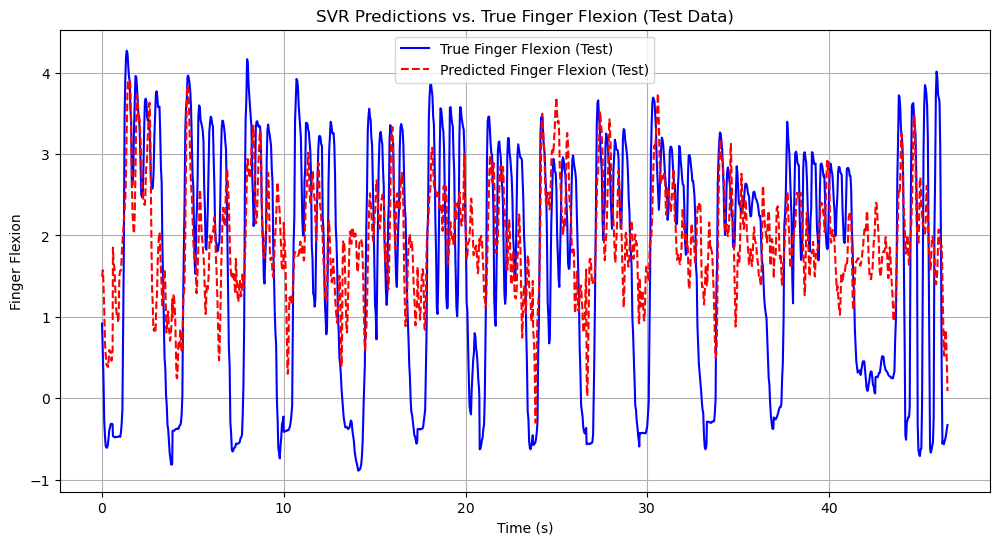

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(time_vector_test, Y_test, label='True Finger Flexion (Test)', color='blue')
plt.plot(time_vector_test, Y_test_pred_svr, label='Predicted Finger Flexion (Test)', linestyle='dashed', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Finger Flexion')
plt.title('SVR Predictions vs. True Finger Flexion (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

### 3) MLP

In [42]:
# Create and fit the MLPRegressor with default parameters
mlp_regressor = MLPRegressor()
mlp_regressor.fit(X_train, Y_train.ravel())

# Make predictions on the test set
Y_test_pred_mlp = mlp_regressor.predict(X_test)

# Compute performance metrics
mse_mlp = mean_squared_error(Y_test, Y_test_pred_mlp)
r2_mlp = r2_score(Y_test, Y_test_pred_mlp)

print("MLPRegressor Performance Metrics:\n")
print(f"Test MSE: {mse_mlp:.4f}")
print(f"Test R2: {r2_mlp:.4f}")

MLPRegressor Performance Metrics:

Test MSE: 2.1684
Test R2: -0.0168


In [43]:
# Define a range of values for hyperparameters
param_dist = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (50, 100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

# Create the MLP regressor
mlp_regressor = MLPRegressor(random_state=42)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    mlp_regressor, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

random_search.fit(X_train, Y_train.ravel())  # X_train and Y_train are your training data

# Print the best hyperparameters and corresponding test performance
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Test MSE: ", -random_search.best_score_)

# Predict on the test data using the best model found by RandomizedSearchCV
best_model = random_search.best_estimator_
Y_test_pred = best_model.predict(X_test)

# Calculate R2 score on the test data
r2 = r2_score(Y_test, Y_test_pred)
print(f"R2 Score on Test Data: {r2:.4f}")


Best Hyperparameters:  {'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 100), 'activation': 'tanh'}
Best Test MSE:  1.855526615191939
R2 Score on Test Data: -0.0726


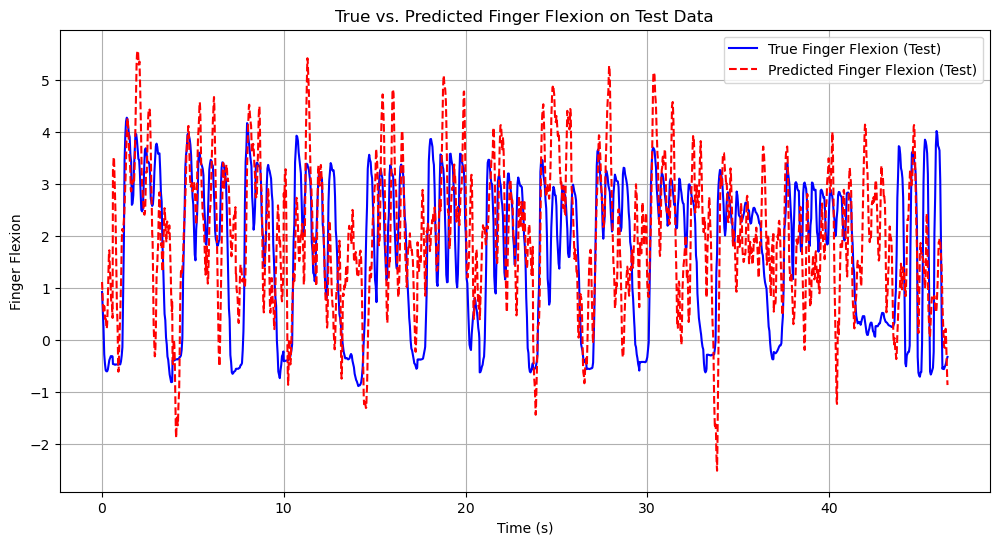

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(time_vector_test, Y_test, label='True Finger Flexion (Test)', color='blue')
plt.plot(time_vector_test, Y_test_pred, label='Predicted Finger Flexion (Test)', linestyle='dashed', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Finger Flexion')
plt.title('True vs. Predicted Finger Flexion on Test Data')
plt.legend()
plt.grid(True)
plt.show()

## Final comparison of the performances